In [1]:
# !pip install matplotlib osmnx  


In [2]:
%matplotlib inline


In [3]:
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import os
from py2neo import Graph, Node, Relationship
from tqdm import tqdm
from dotenv import load_dotenv

load_dotenv()

#  Explicação:

# network_type="drive": baixa apenas ruas para carros.

# Para outros tipos de redes:

# "walk" → Apenas caminhos para pedestres.

# "bike" → Apenas rotas para bicicletas.

# "all" → Todas as conexões (veículos, pedestres, trilhas, etc.).

# Definir a cidade desejada
cidade = "Boituva, Brazil"

# Baixar o grafo viário (apenas ruas)
grafo = ox.graph_from_place(cidade, network_type="drive")



In [4]:
grafo


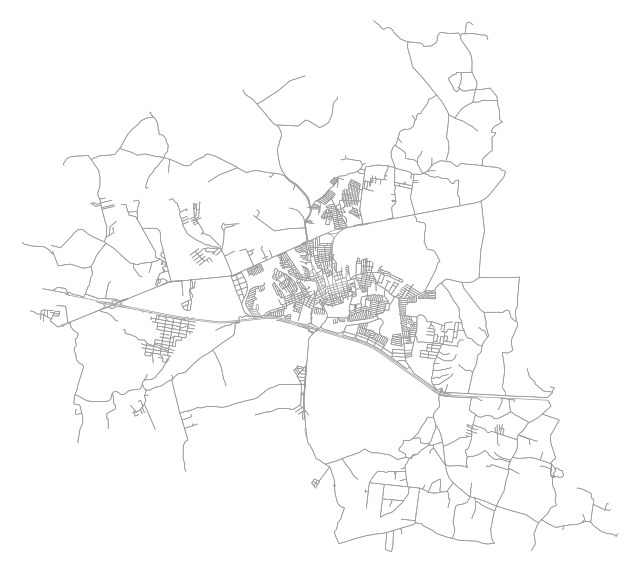

In [5]:
# Desenhar o grafo
fig, ax = ox.plot_graph(grafo, node_size=0, edge_linewidth=0.5, bgcolor="white")


In [6]:
_pass = os.getenv("DB_PASS")
print(_pass)
graph_db = Graph("bolt://localhost:7687", auth=(os.getenv("DB_USER"), os.getenv("DB_PASS")))

test


In [7]:
# Adicionar nós ao Neo4j
node_map = {}

print("Enviando nós...")
for node_id, node_data in tqdm(grafo.nodes(data=True)):
    props = {
        "osmid": node_id,
        "longitude": node_data.get("x"),
        "latitude": node_data.get("y")
    }
    node = Node("Node", **props)
    graph_db.create(node)
    node_map[node_id] = node


Enviando nós...


100%|██████████| 2723/2723 [00:13<00:00, 196.41it/s]


In [ ]:

print("Enviando arestas...")
for u, v, key, edge_data in tqdm(grafo.edges(keys=True, data=True)):
    osmid = edge_data.get("osmid")
    if isinstance(osmid, list):
        osmid = osmid[0]
    props = {
        "length": float(edge_data.get("length", 0)),  # Converte para float nativo
        "highway": str(edge_data.get("highway", "unknown")),
        "name": str(edge_data.get("name", "unknown")),
        "oneway": bool(edge_data.get("oneway", False)),  # Converte para booleano
        "osmid": osmid  # <-- Aqui você salva o ID OSM na relação
    }
    
    rel = Relationship(node_map[u], "ROAD_TO", node_map[v], **props)
    graph_db.create(rel)

print("✅ Grafo enviado para Neo4j com sucesso!")

Enviando arestas...


100%|██████████| 6613/6613 [00:32<00:00, 206.36it/s]

✅ Grafo enviado para Neo4j com sucesso!


: 